##### Copyright 2018 The TensorFlow Authors.

In [7]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Bildklassifikation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/SchuelerUniTUBAF2025/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/vgoehler/SchuelerUniTUBAF2025/blob/main/02_Bild_Klassifizierung.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In diesem Tutorial werden Blumenbilder klassifiziert.

Es folgt den grundlegenden Machine Learning Schritten:

1. Daten betrachten und verstehen
2. Eingabe Pipeline erstellen
3. Model bauen
4. Model trainieren
5. Model testen
6. Model verbessern und den Prozess wiederholen

## Import TensorFlow und benötigte Bibliotheken

In [1]:
# Unterdrücken von C++ Tensorflow Logs
# Use at your Own Risk!
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

## Dataset downloaden und kennenlernen

Dieses Tutorial nutzt ein Dataset mit ca. 3,700 Fotos von Blumen. Das Datenset besteht aus fünf Unterverzeichnissen pro Klasse:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Jetzt steht eine Kopie des Datasets zur Verfügung. Insgesamt gibt es 3,670 Bilder:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Hier einige Rosen:

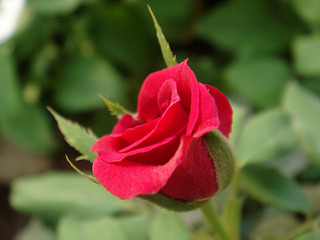

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### Aufgabe
Schaut in jedes der Unterverzeichnisse und schaut euch ein paar der Blumenbilder an.
Nutzt dazu untenstehenden Code.  

Die Unterverzeichnisse sind:
```
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```
Der Index der Liste gibt das entsprechende Bild an.

Fällt euch was auf?


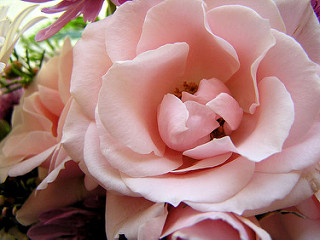

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[-1]))

# Laden der Daten mit Keras

Die Bilder müssen von der Festplatte geladen werden. Dabei hilft die `tf.keras.utils.image_dataset_from_directory` Methode.
Dies erzeugt aus einem Verzeichnis voller Bilder ein `tf.data.Dataset` mit wenigen Codezeilen.

## Datenset anlegen

Parameter:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

80% der Bilder sollten für Training genutzt werden und die restlichen 20% zur Validierung.

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7340 files belonging to 6 classes.
Using 5872 files for training.


I0000 00:00:1770656343.968646  278290 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1770656344.009145  278290 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1770656344.010375  278290 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1770656344.012518  278290 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7340 files belonging to 6 classes.
Using 1468 files for validation.


Die Klassenbezeichner finden sich im `class_names` attribute des Datensets. Diese entsprechen den Unterverzeichnisnamen .

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'flower_photos', 'roses', 'sunflowers', 'tulips']


## Daten anzeigen

Hier die ersten neun Bilder der Datensets.

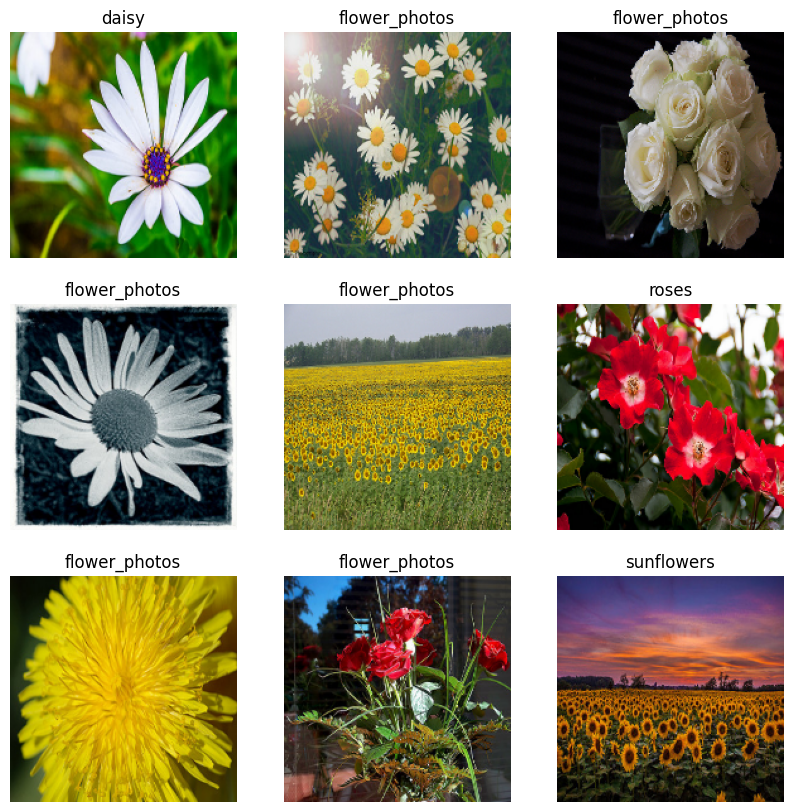

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Performance des Datensets anpassen

Die Puffergrössen müssen angepaßt werden um ein schnelles Laden zu gewährleisten.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardisierung der Daten

Die Rot/Grün/Blau Kanäle der Bilder sind im Bereich von `[0, 255]`.
Das ist nicht ideal für ein Neuronales Netzwerk. Für dieses sollte der Input klein sein.

Wir werden die Werte standardisieren auf einen Interval von `[0, 1]` mittels der Methode `tf.keras.layers.Rescaling`:

In [12]:
normalization_layer = layers.Rescaling(1./255)

Es gibt zwei Möglichkeiten diesen Layer anzuwenden. Wir können ihn direkt auf die Daten anwenden mit `Dataset.map`.

Oder wir können ihn in unser Model einbauen, was wir weiter unten tun werden.

# Das Modell erstellen
Das [Sequential](../../guide/keras/sequential_model.ipynb)-Modell besteht aus drei Faltungsblöcken (`tf.keras.layers.Conv2D`), die jeweils eine Max-Pooling-Schicht (`tf.keras.layers.MaxPooling2D`) enthalten. Den Abschluss bildet eine vollvernetzte Schicht (`tf.keras.layers.Dense`) mit 128 Einheiten, die durch eine ReLU-Aktivierungsfunktion (`'relu'`) aktiviert wird. Dieses Modell wurde nicht auf höchste Genauigkeit optimiert – das Ziel dieses Tutorials ist es, einen Standardansatz aufzuzeigen.

## Convolutions (Faltungsoperationen)
Stell dir eine Convolution wie einen Scanner oder einen Filter vor, der über ein Bild fährt, um Merkmale wie Kanten, Kurven oder Muster zu erkennen.

![[medium.com - understanding convolution](https://medium.com/data-science/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1)](https://miro.medium.com/v2/resize:fit:640/format:webp/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

### Wie es funktioniert:
**Der Filter (Kernel):** Ein kleines Fenster (z. B. 3x3 Pixel groß) gleitet Schritt für Schritt über das Originalbild.

**Die Berechnung:** An jeder Position multipliziert der Filter die Werte der Bildpixel mit seinen eigenen Gewichten und addiert alles zusammen. Das Ergebnis ist ein einzelner neuer Wert.

**Die Feature Map:** Aus all diesen neuen Werten entsteht ein neues, meist kleineres Bild – die sogenannte "Feature Map". Sie hebt bestimmte Eigenschaften des Bildes hervor (z. B. vertikale Linien).

### Warum machen wir das?
Anstatt dass der Computer versucht, das gesamte Bild auf einmal zu verstehen, lernt er durch Convolutions zuerst kleine Details. In den tieferen Schichten setzt er diese Details dann zu komplexeren Objekten (wie Augen, Gesichtern oder Autos) zusammen.

**Kurz gesagt:** Convolutions erlauben es dem Modell, sich auf das Wesentliche zu konzentrieren und räumliche Hierarchien in Daten zu erkennen.


In [13]:
num_classes = 6

model = Sequential([
  layers.Input([img_height, img_width, 3]),
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Kompilieren des Models



In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Übersicht

Mit der `Model.summary` Methode können wir uns alle Layer des Models anschauen:

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

## Training des Models

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


I0000 00:00:1770656381.592777  278385 service.cc:146] XLA service 0x7760ac004c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770656381.592803  278385 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6


 20/184 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4410 - loss: 1.9011

I0000 00:00:1770656383.957156  278385 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.4894 - loss: 1.4864 - val_accuracy: 0.4932 - val_loss: 1.2579
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4830 - loss: 1.2447 - val_accuracy: 0.4707 - val_loss: 1.2765
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5016 - loss: 1.1415 - val_accuracy: 0.4448 - val_loss: 1.1927
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4896 - loss: 1.0864 - val_accuracy: 0.4196 - val_loss: 1.2538
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4908 - loss: 1.0191 - val_accuracy: 0.3617 - val_loss: 1.2987
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5064 - loss: 0.9314 - val_accuracy: 0.3399 - val_loss: 1.3274
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5197 - loss: 0.8644 - val_accuracy: 0.2943 - val_loss: 1.3893
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5249 - loss: 0.8200 - val_accuracy: 0.2166 - va

## Anzeigen der Trainingsresultate

Erstellen eines Diagramms auf dem Trainingsset und dem Validierungsset:

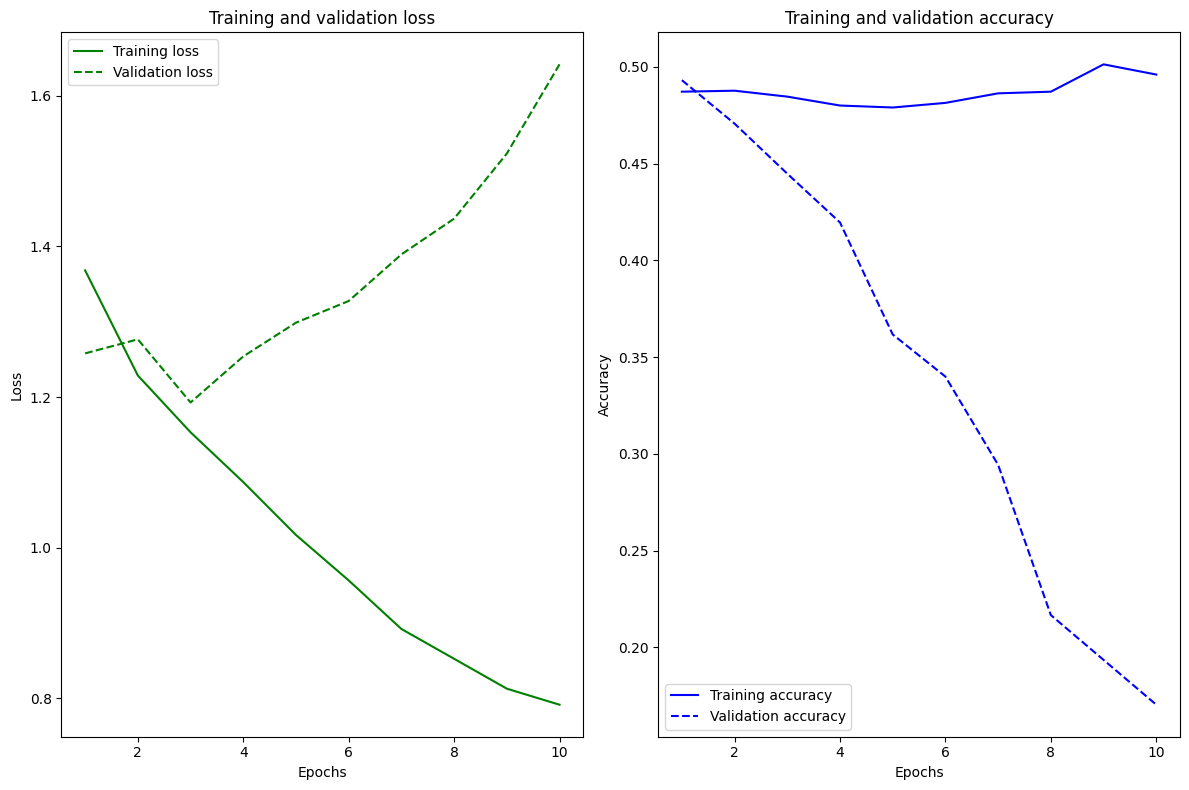

In [18]:
import matplotlib.pyplot as plt

def plot_acc_val(history_dict):

    def plot_subplot(type, axis, color, train, val):
        axis.plot(epochs, train, '%s'%color, label='Training %s'%type)
        axis.plot(epochs, val, '%s--'%color, label='Validation %s'%type)
        axis.set_title("Training and validation %s"%type)
        axis.set_xlabel('Epochs')
        axis.set_ylabel(type.capitalize())
        axis.legend()
    
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    accuracy = history_dict.get('accuracy', history_dict.get('acc'))
    val_accuracy = history_dict.get('val_accuracy', history_dict.get('val_acc'))
    epochs = range(1, len(loss) + 1)

    # Creating subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    # Plotting the training and validation loss
    plot_subplot('loss', ax1, 'g', loss, val_loss)

    # Plotting the training and validation accuracy
    if accuracy is not None and val_accuracy is not None:
        plot_subplot('accuracy', ax2, 'b', accuracy, val_accuracy)

    plt.tight_layout()
    plt.show()

plot_acc_val(history.history)


Die Plots zeigen dass die Trainingsgenauigkeit und die Validierungsgenauigkeit sich um Größeneinheiten unterscheiden. Und die Genauigkeit des Modells liegt lediglich bei 60%.

Was ist also schief gelaufen und was können wir dagegen tun?

## Overfitting

Im obigen Diagramm wächst die Trainingsgenauigkeit Linear, aber die Validierungsgenauigkeit bricht bei ca. 60% ab.
Ebenso ist die Differenz zwischen Training und Validierung sehr groß. Dies ist ein Zeichen für [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Bei kleinen Mengen an Trainingsbeispielen lernen die Modelle manchmal unerwünschte Details oder Hintergrundrauschen der Trainingsbilder. Wenn dies zuviel passiert hat das einen negativen Einfluss auf die Performance.
Diese Overfitting bedeutet das das Model Schwierigkeiten hat sich auf ein neues Dataset zu Generalisieren.

Wir werden hier *data augmentation* nutzen und *Dropout* Layer zeigen.

## Data augmentation

Overfitting passiert generell when es zu wenige Trainingsbilder gibt.
Mit Data Augmentation werden aus alten Bildern neue Bilder generiert die geringfügig verändert werden um so in Summe aus wenigen Bildern mehr zu machen.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/home/vgoehler/Applications/anaconda3/envs/usegpu/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Schauen wir uns einige der neuen Bilder an:

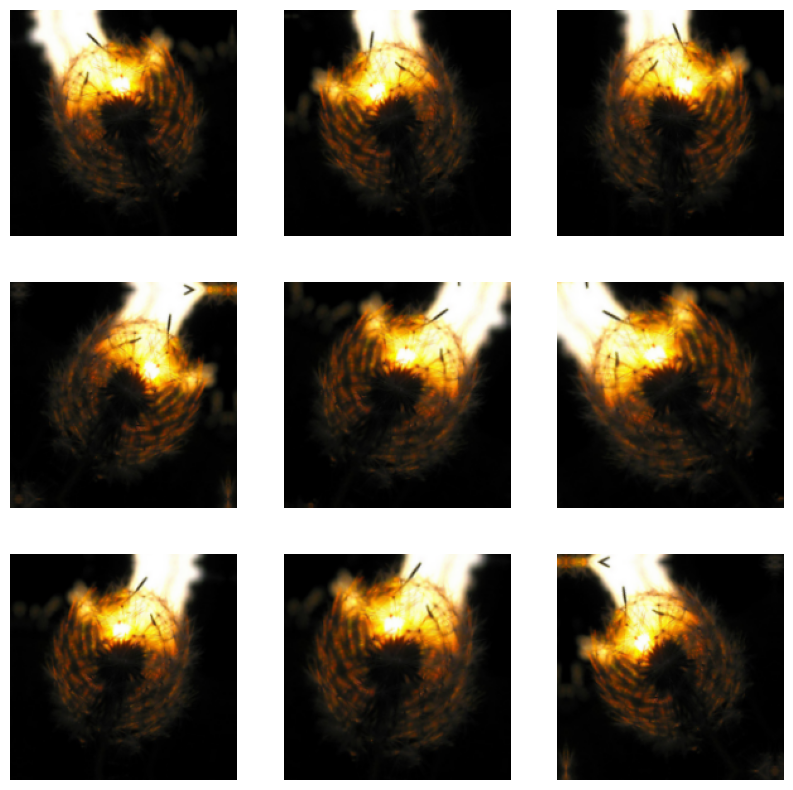

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Dropout

Eine andere Technik um Overfitting zu vermeiden ist der [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) im Netzwerk.

Ein Dropoutlayer läßt zufällig einige Eingabe aus der Verarbeitung im Netzwerk fallen (die Aktivierung wird auf 0 gesetzt).
Bei dem Dropoutlayer kann man mit Kommazahlen die Prozentanzahl an ignorierten Eingaben einstellen (0.1=10% etc.).

Wir erzeugen jetzt ein neues Netzwerk mit  `tf.keras.layers.Dropout` Layern und werden das dann mit unseren data augmented Eingaben trainieren:

In [21]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilieren und trainieren des Models

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,414 (15.22 MB)

 Trainable params: 3,989,414 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
epochs = 10
history_imp = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


W0000 00:00:1770656435.249909  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.263331  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.264381  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.265357  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.266145  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.266957  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.267816  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.269601  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656435.271393  278379 gp

  6/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.3730 - loss: 1.7365

W0000 00:00:1770656436.115242  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.116531  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.119309  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.126277  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.135441  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.136334  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.137376  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.138431  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656436.139785  278379 gp

159/184 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4829 - loss: 1.4259

W0000 00:00:1770656438.140768  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.141474  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.142155  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.142842  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.143458  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.144083  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.144705  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.145718  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.146731  278379 gp

164/184 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4830 - loss: 1.4235

W0000 00:00:1770656438.364895  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.365785  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.366628  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.367476  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.368266  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.369351  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.370244  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.371196  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656438.372282  278386 gp

184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4833 - loss: 1.4141 - val_accuracy: 0.4401 - val_loss: 1.2879
Epoch 2/10
  1/184 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4375 - loss: 1.2777

W0000 00:00:1770656439.069815  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.070682  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.071496  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.072308  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.073010  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.073733  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.074455  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.075846  278386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656439.077244  278386 gp

184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4846 - loss: 1.2451 - val_accuracy: 0.4734 - val_loss: 1.2090
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5028 - loss: 1.1750 - val_accuracy: 0.4823 - val_loss: 1.1734
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4959 - loss: 1.1585 - val_accuracy: 0.4503 - val_loss: 1.1507
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4994 - loss: 1.1132 - val_accuracy: 0.4755 - val_loss: 1.1449
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4981 - loss: 1.0927 - val_accuracy: 0.4462 - val_loss: 1.1175
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4779 - loss: 1.0777 - val_accuracy: 0.4755 - val_loss: 1.0913
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4797 - loss: 1.0740 - val_accuracy: 0.4632 - val_loss: 1.0863
Epoch 9/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5061 - loss: 1.0423 - val_accuracy: 0.452

## Anzeigen der Trainingsergebnisse

Nachdem wir die Data Augmentation und den `tf.keras.layers.Dropout` Layer eingesetzt haben ist weniger overfitting als vorher zu erkennen. Ebenso ist die Genauigkeit des Trainings und des Validierungsdataset näher bei einander.

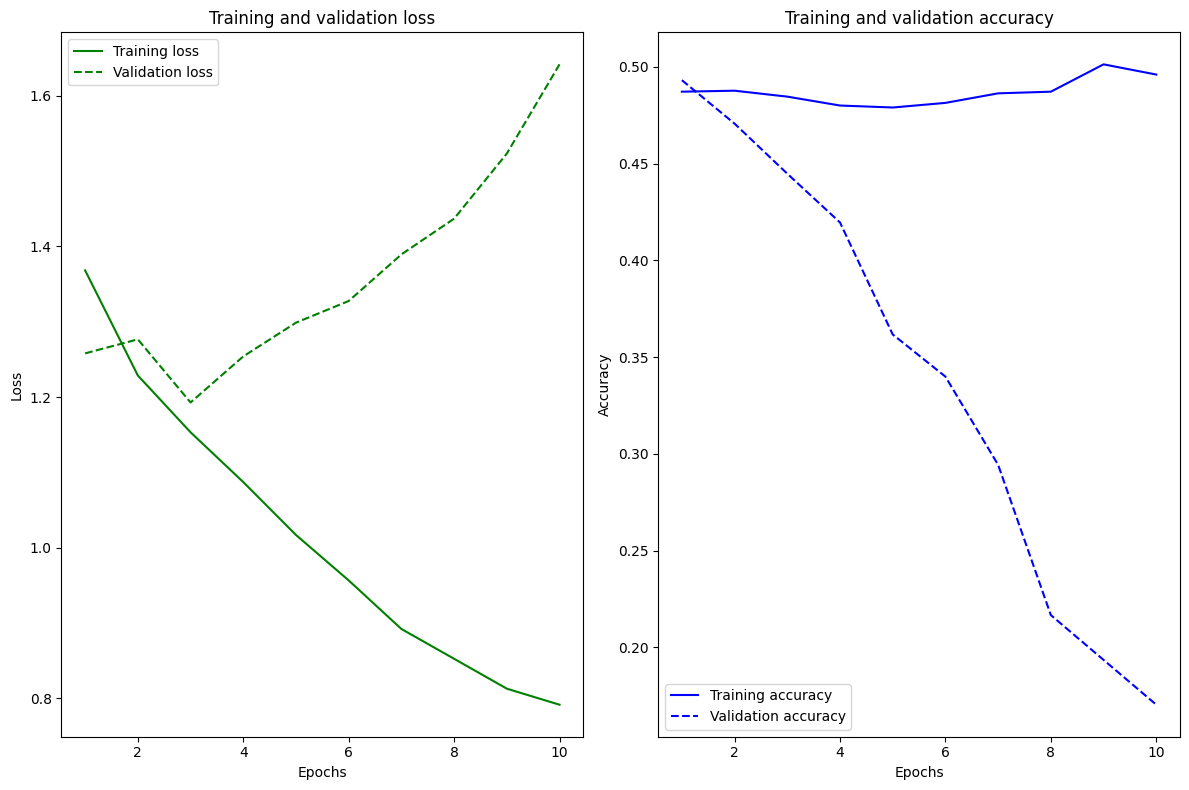

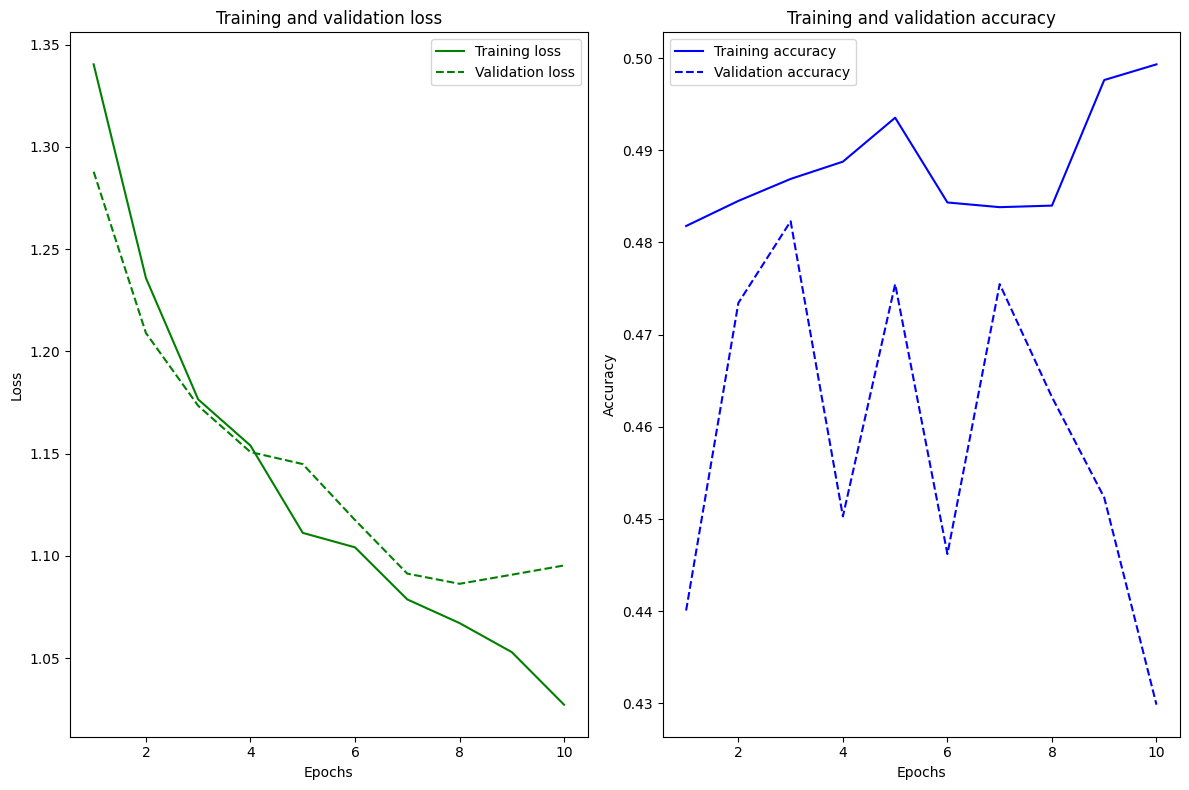

In [25]:
plot_acc_val(history.history)
plot_acc_val(history_imp.history)

## Vorhersage auf neuen Daten

Schlußendlich werden wir unser Model auf neuen Daten anwenden die nicht im Trainings oder Validierungs Set enthalten waren.
![](https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg)

In [26]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Dieses Bild gehört zu {} mit {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Dieses Bild gehört zu sunflowers mit 52.82 %.


W0000 00:00:1770656516.683075  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.683669  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.684225  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.684788  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.685348  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.685899  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.686482  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.687044  278379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1770656516.687610  278379 gp

### Experiment

Nutze untenstehenden Code um das Model anzupassen.
Wie hoch kannst du die Genauigkeit heben?  
  
Passe an:

- Data Augmentation (mögliche Funktionen werden weiter unten gezeigt)
- Parameter des Netzes
    - Layer (weitere hinzufügen, auch DropOut)
    - DropOut Parameter zwischen 0 und 1
    - Aktivierungsfunktion (relu, gelu, selu, sigmoid, etc.)
    - Layer Initializierung (he_normal, he_uniform, glorot_uniform, glorot_normal, random_normal)
    - Anzahl der Neuronen
    - Optimizers (adam, nadam, sgd)
---

#### Data Augmentation
Out of the `tf.keras.layers` package  

#### [RandomCrop](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_crop/) layer
mandatory:
- height
- width
#### [RandomFlip](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_flip/) layer
- optional:
- mode [horizontal", "vertical", or "horizontal_and_vertical"]
#### [RandomTranslation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_translation/) layer
mandatory:
- height_factor
- width_factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomRotation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_rotation/) layer
mandatory:
- factor
optional:
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomZoom](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/) layer
mandatory:
- height_factor
optional:
- width_factor
- fill_mode ["constant", "nearest", "wrap" and "reflect"]
#### [RandomContrast](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_contrast/) layer
mandatory:
- factor
#### [RandomBrightness](https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_brightness/) layer
mandatory:
- factor

Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4386 - loss: 2.9296 - val_accuracy: 0.5095 - val_loss: 1.2693
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4858 - loss: 1.2677 - val_accuracy: 0.5014 - val_loss: 1.1962
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4841 - loss: 1.2291 - val_accuracy: 0.5014 - val_loss: 1.2328
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4946 - loss: 1.1674 - val_accuracy: 0.4918 - val_loss: 1.1727
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4917 - loss: 1.1564 - val_accuracy: 0.4946 - val_loss: 1.1442
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4981 - loss: 1.1162 - val_accuracy: 0.4748 - val_loss: 1.1574
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4743 - loss: 1.1015 - val_accuracy: 0.4843 - val_loss: 1.2023
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4943 - loss: 1.0893 - val_accu

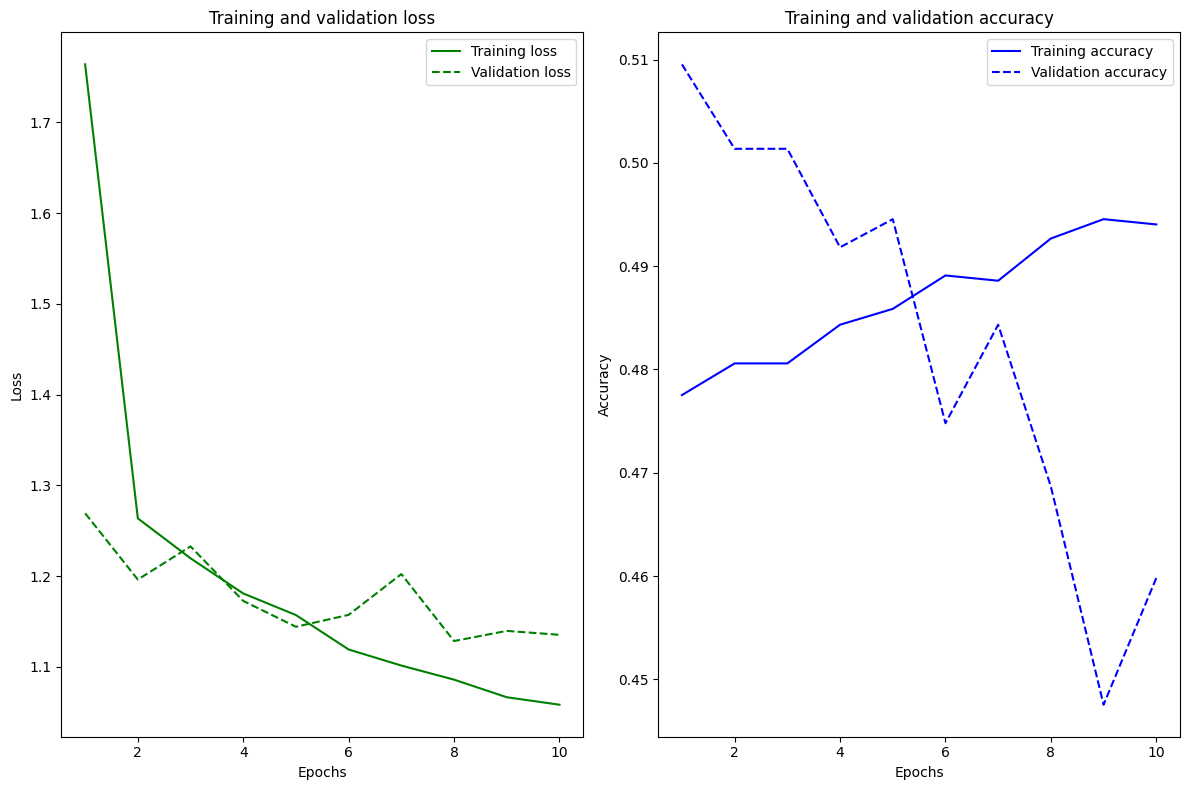

In [27]:
# RESET
tf.keras.backend.clear_session()


model_exp = Sequential([
    # data augmentation part
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # normalization
    layers.Rescaling(1./255),
    # Neural Net
    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    # Entscheidungsebene
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    # letzen Layer nicht ändern, brauchen wir !
    layers.Dense(num_classes)
])


model_exp.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


history_exp = model_exp.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

plot_acc_val(history_exp.history)